In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

import seaborn as sns
from sklearn import datasets, model_selection
from sklearn.base import BaseEstimator
from sklearn.datasets import fetch_openml, fetch_20newsgroups

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier, KDTree
from sklearn.metrics import accuracy_score, pairwise
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from scipy.spatial import distance

##### Задание 1, 2.

In [2]:
class MyKNeighborsClassifier(BaseEstimator):
    
    def __init__(self, n_neighbors, algorithm='brute', metric='euclidean'):
        self.n_neighbors = n_neighbors
        self.algorithm = algorithm
        self.metric = metric
    
    def fit(self, X, y):
        self.X_train = X
        self.y_train = y
        if self.algorithm == 'kd_tree':
            self.tree = KDTree(X)
        return self
    
    def predict(self, X):
        if self.algorithm == 'kd_tree':
            distances, inds = self.tree.query(X, k=self.n_neighbors)
        elif self.algorithm == 'brute':    
            distances = pairwise.pairwise_distances(X, self.X_train, metric=self.metric)
            inds = np.argpartition(distances, self.n_neighbors, axis=1)[:, :self.n_neighbors]
    
        nearest = np.take(self.y_train, inds)
        return np.apply_along_axis(func1d=lambda x: np.argmax(np.bincount(x)), axis=1, arr=nearest)

In [3]:
iris = datasets.load_iris()

In [4]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [5]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='brute')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='brute')

In [6]:
clf.fit(X_train, y_train)
my_clf.fit(X_train, y_train)

MyKNeighborsClassifier(n_neighbors=2)

In [7]:
sklearn_pred = clf.predict(X_test)
my_clf_pred = my_clf.predict(X_test)
assert abs( accuracy_score(y_test, my_clf_pred) -  accuracy_score(y_test, sklearn_pred ) )<0.005, "Score must be simillar"

##### Задание 2

In [8]:
%time clf.fit(X_train, y_train)

Wall time: 1 ms


KNeighborsClassifier(algorithm='brute', n_neighbors=2)

In [9]:
%time my_clf.fit(X_train, y_train)

Wall time: 0 ns


MyKNeighborsClassifier(n_neighbors=2)

In [10]:
%time clf.predict(X_test)

Wall time: 2 ms


array([0, 1, 0, 0, 1, 2, 0, 2, 1, 1, 1, 2, 1, 2, 0])

In [11]:
%time my_clf.predict(X_test)

Wall time: 1 ms


array([0, 1, 0, 0, 1, 2, 0, 2, 1, 1, 1, 2, 1, 2, 0], dtype=int64)

##### Задание 3

In [12]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')

In [13]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [14]:
%time clf.fit(X_train, y_train)

Wall time: 1 ms


KNeighborsClassifier(algorithm='kd_tree', n_neighbors=2)

In [15]:
%time my_clf.fit(X_train, y_train)

Wall time: 0 ns


MyKNeighborsClassifier(algorithm='kd_tree', n_neighbors=2)

In [16]:
%time clf.predict(X_test)

Wall time: 2 ms


array([2, 0, 1, 0, 0, 2, 0, 2, 1, 2, 2, 2, 1, 1, 0])

In [17]:
%time my_clf.predict(X_test)

Wall time: 0 ns


array([2, 0, 1, 0, 0, 2, 0, 2, 1, 2, 2, 2, 1, 1, 0], dtype=int64)

In [18]:
sklearn_pred = clf.predict(X_test)
my_clf_pred = my_clf.predict(X_test)
assert abs( accuracy_score(y_test, my_clf_pred) -  accuracy_score(y_test, sklearn_pred ) )<0.005, "Score must be simillar"

##### Задание 4 (2.5 балла)

In [19]:
newsgroups = fetch_20newsgroups(subset='train',remove=['headers','footers', 'quotes'])

In [20]:
data = newsgroups['data']
target = newsgroups['target']

In [21]:
vectorizer = CountVectorizer(max_df=0.7)
X_train = vectorizer.fit_transform(data)
y_train = target

In [22]:
kf = model_selection.KFold(n_splits=3)

In [23]:
def tune_knn(model, X, y, metric='euclidean'):
    kf = model_selection.KFold(n_splits=3)
    accs = []
    begin = 2
    end = 20
    for k in range(begin, end + 1):
        cur_accs = []
        my_knn = model(n_neighbors=k, algorithm='brute', metric=metric)
        for train_index, val_index in kf.split(X):
#             print(X[train_index].shape, y[train_index])
            X_train, X_val = X[train_index], X[val_index]
            y_train, y_val = y[train_index], y[val_index]
            my_knn.fit(X_train, y_train)
            my_y_val = my_knn.predict(X_val)
            cur_accs.append(accuracy_score(my_y_val, y_val))
        accs.append(sum(cur_accs) / len(cur_accs))
    return accs.index(max(accs)) + begin, accs

In [24]:
k_neig, accs = tune_knn(MyKNeighborsClassifier, X_train, y_train)
k_neig

11

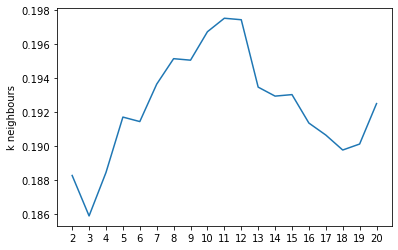

In [25]:
plt.xticks(range(2, 21))
plt.plot(range(2, 21), accs)
plt.ylabel("validation acc")
plt.ylabel("k neighbours")
plt.show()

##### Применим косинусную метрику вместо евклидовой.

In [26]:
k_neig, accs = tune_knn(MyKNeighborsClassifier, X_train, y_train, metric='cosine')
k_neig

2

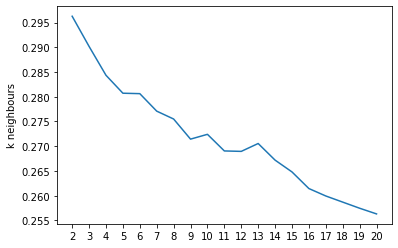

In [27]:
plt.xticks(range(2, 21))
plt.plot(range(2, 21), accs)
plt.ylabel("validation acc")
plt.ylabel("k neighbours")
plt.show()

##### Применим tf-idf векторизацию + евклидова метрика.

In [28]:
vectorizer = TfidfVectorizer(max_df=0.7)
X_train = vectorizer.fit_transform(data)
print(X_train.shape, y_train.shape)

(11314, 101629) (11314,)


In [29]:
k_neig, accs = tune_knn(MyKNeighborsClassifier, X_train, y_train, metric='euclidean')
k_neig

3

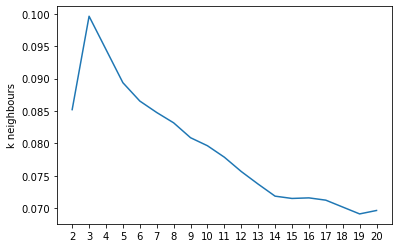

In [30]:
plt.xticks(range(2, 21))
plt.plot(range(2, 21), accs)
plt.ylabel("validation acc")
plt.ylabel("k neighbours")
plt.show()

##### Применим tf-idf векторизацию + cosine метрика.

In [31]:
k_neig, accs = tune_knn(MyKNeighborsClassifier, X_train, y_train, metric='cosine')
k_neig

9

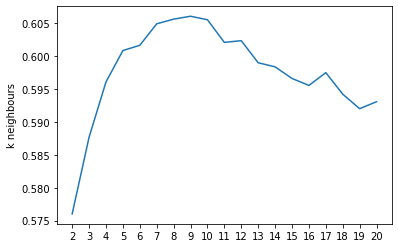

In [32]:
plt.xticks(range(2, 21))
plt.plot(range(2, 21), accs)
plt.ylabel("validation acc")
plt.ylabel("k neighbours")
plt.show()

#### Получаем, что лучшая модель - tf-idf векторизация, cosine метрика и 9 ближайших соседей

### Загрузим тестовую часть выборки

In [33]:
newsgroups_test = fetch_20newsgroups(subset='test',remove=['headers','footers', 'quotes'])
newsgroups_train = fetch_20newsgroups(subset='train',remove=['headers','footers', 'quotes'])

In [34]:
data_test = newsgroups_test['data']
y_test = newsgroups_test['target']
data_train = newsgroups_train['data']
y_train = newsgroups_train['target']

In [35]:
vectorizer = TfidfVectorizer(max_df=0.7)
vectorizer = vectorizer.fit(data_train)
X_train = vectorizer.transform(data_train)
X_test = vectorizer.transform(data_test)
print(X_test.shape, y_test.shape, X_train.shape)

(7532, 101629) (7532,) (11314, 101629)


In [36]:
my_knn = MyKNeighborsClassifier(n_neighbors=9, algorithm='brute', metric='cosine')

In [37]:
my_knn.fit(X_train, y_train)

MyKNeighborsClassifier(metric='cosine', n_neighbors=9)

In [38]:
print(X_train.shape, X_test.shape)

test_labels = my_knn.predict(X_test)
accuracy_score(test_labels, y_test)

(11314, 101629) (7532, 101629)


0.5396972915560276

Точность на тестовой выборки примерно на 0.07 меньше чем на кросс-валидации.\
Это могло произойти, потому что в тестовой выборке встретились новые слова, которые не встречались в обучающей.